<a href="https://colab.research.google.com/github/nv-hiep/ML/blob/main/h6_sklearn_decision_tree_and_DecisionTree__from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Trees

# Import libraries

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

from IPython.display import Image

from matplotlib import rc
rc('animation', html='jshtml')

%matplotlib inline

# 1. Decision Tree from Scratch in Python

# 1.1 What is a decision tree?

Decision trees can be used for regression (continuous real-valued output,
e.g. predicting the price of a house) or classification (categorical output,
e.g. predicting email spam vs. no spam), but here we will focus on classification. A decision tree classifier is a binary tree where predictions are made by traversing the tree from root to leaf — at each node, we go left if a feature is less than a threshold, right otherwise. Finally, each leaf is associated with a class, which is the output of the predictor.

For example consider this Wireless Indoor Localization Dataset. It gives 7 features representing the strength of 7 Wi-Fi signals perceived by a phone in an apartment, along with the indoor location of the phone which can be Room 1, 2, 3 or 4.

+-------+-------+-------+-------+-------+-------+-------+------+

| W1 | W2 | W3 | W4 | W5 | W6 | W7 | Room |

+-------+-------+-------+-------+-------+-------+-------+------+

|  -64  |  -55  |  -63  |  -66  |  -76  |  -88  |  -83  |   1  |

|  -49  |  -52  |  -57  |  -54  |  -59  |  -85  |  -88  |   3  |

|  -36  |  -60  |  -53  |  -36  |  -63  |  -70  |  -77  |   2  |

|  -61  |  -56  |  -55  |  -63  |  -52  |  -84  |  -87  |   4  |

|  -36  |  -61  |  -57  |  -27  |  -71  |  -73  |  -70  |   2  |

## 1.2 Gini impurity

Decision trees use the concept of **Gini impurity** to describe how homogeneous or “pure” a node is.

A node is pure (G = 0) if all its samples belong to the same class, while a node with many samples from many different classes will have a Gini closer to 1.

More formally the Gini impurity of **n training samples** split across **k classes** is defined as:

$G = 1 - \sum_{k=1}^{n}p_{k}^2$

where $p_{k}$ is the fraction of samples belonging to class k.

For example if a node contains 05 samples, with 02 of class Room 1, 02 of class Room 2, 01 of class Room 3 and 00 of class Room 4, then:

$G = 1 - \sum_{k=1}^{n}p_{k}^2 = 1 - (\frac{2}{5})^2 - (\frac{2}{5})^2- (\frac{1}{5})^2 = 0.64$

## 1.3 CART algorithm

The training algorithm is a recursive algorithm called CART, short for Classification And Regression Trees. Each node is split so that the Gini impurity of the children (more specifically the average of the Gini of the children weighted by their size) is minimized.

The recursion stops when the maximum depth, a hyperparameter, is reached, or when no split can lead to two children purer than their parent. Other hyperparameters can control this stopping criterion (crucial in practice to avoid overfitting), but we won’t cover them here.

For example, if X = [[1.5], [1.7], [2.3], [2.7], [2.7]] and y = [1, 1, 2, 2, 3] then an optimal split is X < 2, because as computed above the Gini of the parent is 0.64, and the Gini of the children after the split is:

Left: 2 of 5 values with y =[1, 1]: $ \rightarrow G_{left} = 1 - (\frac{2}{2})^2 = 0$

Right: 3 of 5 values with y = [2, 2, 3]: $ \rightarrow G_{right} = 1 - (\frac{2}{3})^2 - (\frac{1}{3})^2= \frac{4}{9}$

$\rightarrow G = \frac{2}{5} G_{left} + \frac{3}{5} G_{right} = \frac{2}{5} \times 0 + \frac{3}{5} \times \frac{4}{9} = \frac{4}{15} \approx 0.27$

You can convince yourself that no other split yields a lower Gini.


## 1.4 Finding the optimal feature and threshold

The key to the CART algorithm is finding the optimal feature and threshold such that the Gini impurity is minimized. To do so, we try all possible splits and compute the resulting Gini impurities.
But how can we try all possible thresholds for a continuous values? There is a simple trick — sort the values for a given feature, and consider all midpoints between two adjacent values. Sorting is costly, but it is needed anyway as we will see shortly.
Now, how might we compute the Gini of all possible splits?
The first solution is to actually perform each split and compute the resulting Gini. Unfortunately this is slow, since we would need to look at all the samples to partition them into left and right. More precisely, it would be n splits with O(n) operations for each split, making the overall operation O(n²).

**A faster approach is to iterate through all features, and for each feature:**

**1. iterate through the sorted feature values as possible thresholds.**

**2. keep track of the number of samples per class on the left and on the right.**

**3. increment/decrement them by 1 after each threshold. From them we can easily compute Gini in constant time.**

Indeed if m is the size of the node and $m_k$ the number of samples of class k in the node, then

$G = 1 - \sum_{k=1}^{n}p_{k}^2 = 1 - \sum_{k=1}^{n} (\frac{m_k}{m})^2 $

and since after seeing the $i^{th}$ threshold there are $i$ elements on the left and $m–i$ on the right,

$G^{left}_i = 1 - \sum_{k=1}^{n} (\frac{m_k^{left}}{i})^2 $

and 

$G^{right}_i = 1 - \sum_{k=1}^{n} (\frac{m_k^{right}}{m-i})^2 $

The resulting Gini is a simple weighted average:

$G_i = \frac{i}{m} G^{left}_{i} + \frac{m-i}{m} G^{right}_{i} $

## 1.5 Python code for SimpleDecisionClassifier

In [2]:
class Node:
  '''
  Properties of a node
  '''
  def __init__(self, classes, gini, n_samples, n_samples_per_class, predicted_class_id):
    self.classes             = classes
    self.predicted_class_id  = predicted_class_id
    self.gini                = gini
    self.n_samples           = n_samples
    self.n_samples_per_class = n_samples_per_class
    self.threshold           = 0.
    self.feature             = None
    self.feature_id          = None
    self.left                = None
    self.right               = None

  def debug(self, feature_names, class_names, show_details):
    '''
    Print an ASCII visualization of the tree
    '''
    lines, _, _, _ = self._debug_aux( feature_names, class_names, show_details, root=True )
    for line in lines:
      print(line)

  def _debug_aux(self, feature_names, class_names, show_details, root=False):
      # See https://stackoverflow.com/a/54074933/1143396 for similar code.
      is_leaf = not self.right
      if is_leaf:
          lines = ['class = ' + class_names[self.predicted_class_id]]
      else:
          lines = [
              "Ft. {} < {:.2f}".format(feature_names[self.feature_id], self.threshold)
          ]
      if show_details:
          lines += [
              "gini = {:.2f}".format(self.gini),
              "samples = {}".format(self.n_samples),
              "val = {}".format( self.n_samples_per_class),
          ]
      width = max(len(line) for line in lines)
      height = len(lines)
      if is_leaf:
          lines = ["║ {:^{width}} ║".format(line, width=width) for line in lines]
          lines.insert(0, "╔" + "═" * (width + 2) + "╗")
          lines.append("╚" + "═" * (width + 2) + "╝")
      else:
          lines = ["│ {:^{width}} │".format(line, width=width) for line in lines]
          lines.insert(0, "┌" + "─" * (width + 2) + "┐")
          lines.append("└" + "─" * (width + 2) + "┘")
          lines[-2] = "┤" + lines[-2][1:-1] + "├"
      width += 4  # for padding

      if is_leaf:
          middle = width // 2
          lines[0] = lines[0][:middle] + "╧" + lines[0][middle + 1 :]
          return lines, width, height, middle

      # If not a leaf, must have two children.
      left, n, p, x = self.left._debug_aux(feature_names, class_names, show_details)
      right, m, q, y = self.right._debug_aux(feature_names, class_names, show_details)
      top_lines = [n * " " + line + m * " " for line in lines[:-2]]
      # fmt: off
      middle_line = x * " " + "┌" + (n - x - 1) * "─" + lines[-2] + y * "─" + "┐" + (m - y - 1) * " "
      bottom_line = x * " " + "│" + (n - x - 1) * " " + lines[-1] + y * " " + "│" + (m - y - 1) * " "
      # fmt: on
      if p < q:
          left += [n * " "] * (q - p)
      elif q < p:
          right += [m * " "] * (p - q)
      zipped_lines = zip(left, right)
      lines = (
          top_lines
          + [middle_line, bottom_line]
          + [a + width * " " + b for a, b in zipped_lines]
      )
      middle = n + width // 2
      if not root:
          lines[0] = lines[0][:middle] + "┴" + lines[0][middle + 1 :]
      return lines, n + m + width, max(p, q) + 2 + len(top_lines), middle

In [3]:
class SimpleDecisionTreeClassifier:
  '''
  A simple Decision Tree Classifier using Gini impurity
  '''

  def __init__(self, max_depth=None):
    self.max_depth = max_depth
  
  def fit(self, X, y):
    print('Training...')
    self.n_samples, self.n_features = X.shape
    self.classes                    = list(set(y))
    self.n_classes                  = len( self.classes )
    self.tree_                      = self._grow_tree(X, y)
    print('Training completed!')
  
  def _gini(self, y):
    '''
    Compute Gini impurity of a non-empty node.
    Gini impurity is defined as Σ p(1-p) over all classes, with p the frequency of a
    class within the node. Since Σ p = 1, this is equivalent to 1 - Σ p^2.
    '''
    class_counts = [sum(y==ci) for ci in self.classes]
    return 1. - sum( [ (mk/y.size)**2 for mk in class_counts ] )
  
  def _split(self, X, y):
    '''
    Find the best split for a node.
    ``Best'' means that the average impurity of the two children, weighted by their
    population, is the smallest possible. Additionally it must be less than the
    impurity of the current node.
    To find the best split, we loop through all the features, and consider all the
    midpoints between adjacent training samples as possible thresholds. We compute
    the Gini impurity of the split generated by that particular feature/threshold
    pair, and return the pair with smallest impurity.
    
    Returns:
      best_feature_id: Index of the feature for best split, or None if no split is found.
      best_threshold: Threshold to use for the split, or None if no split is found.
    '''
    # Number of samples, Number of features
    n_samples, n_features = X.shape

    if n_samples < 2:
      print('N-samples must be greater than 1!')
      return None, None
    
    classes      = list(set(y))
    n_classes    = len(classes)
    class_counts = [sum(y==ci) for ci in classes]

    best_gini    = 1. - sum( [ (mk/n_samples)**2 for mk in class_counts ] )

    if best_gini == 0.:
      return None, None
    
    best_feature_id, best_threshold = None, None

    for i in range(n_features):
      threshold_i, classes_i = zip(   *sorted(zip( X[:,i],y ), key=lambda x: x[0])   )
      class_counts_left  = [0] * n_classes
      class_counts_right = class_counts.copy()

      for j in range(1, n_samples):
        class_ij = classes_i[j]
        class_id = classes.index(class_ij)

        class_counts_left[class_id]  += 1
        class_counts_right[class_id] -= 1

        gini_left  = 1. - sum( [ (mk/j)**2 for mk in class_counts_left ] )
        gini_right = 1. - sum( [ (mk/(n_samples-j))**2 for mk in class_counts_right ] )

        current_gini = ( (j+1)*gini_left + (n_samples-j-1)*gini_right ) / n_samples

        # The following condition is to make sure we don't try to split two
        # points with identical values for that feature, as it is impossible
        # (both have to end up on the same side of a split).
        if threshold_i[j] == threshold_i[j-1]:
          continue

        if current_gini < best_gini:
          best_gini       = current_gini
          best_feature_id = i
          best_threshold  = (threshold_i[j] + threshold_i[j-1]) / 2.
    
    return best_feature_id, best_threshold

  def _grow_tree(self, X, y, depth=0):
    '''
    Build a decision tree by recursively finding the best split.
    '''
    # Population for each class in current node. The predicted class is the one with largest population.
    class_counts  = [sum(y==ci) for ci in self.classes]
    pred_class_id = np.argmax(class_counts)

    node = Node(classes=self.classes, gini=self._gini(y), n_samples=y.size,
                n_samples_per_class=class_counts, predicted_class_id=pred_class_id)

    if depth < self.max_depth:
      feature_id, threshold = self._split(X, y)
      if feature_id is not None:
        low_idx = X[:, feature_id] < threshold

        X_low   = X[low_idx, :]
        y_low   = y[low_idx]

        X_high  = X[~low_idx, :]
        y_high  = y[~low_idx]

        node.threshold  = threshold
        node.feature_id = feature_id

        node.left  = self._grow_tree(X_low, y_low, depth=depth+1)
        node.right = self._grow_tree(X_high, y_high, depth=depth+1)
      # End - if
    # End - if: depth
    
    return node
  
  def debug(self, feature_names, class_names, show_details=True):
    '''Print ASCII visualization of decision tree.'''
    self.tree_.debug(feature_names, class_names, show_details)
  
  def predict(self, Xinputs):
    return [ self.predict_one(x_in) for x_in in Xinputs ]

  def predict_one(self, X_in):
    node = self.tree_
    while node.left is not None:
      if X_in[node.feature_id] < node.threshold:
        node = node.left
      else:
        node = node.right

    return node.predicted_class_id
# End - Class

# 2. Iris dataset

## 2.1 Read data

In [4]:
from sklearn.datasets import load_iris

iris = load_iris()
X    = iris.data[:, 2:] # petal length and width
y    = iris.target

print( 'IRIS keys: ', iris.keys() )
print( 'IRIS data: ', iris.data[:5] )

IRIS keys:  dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])
IRIS data:  [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]


In [5]:
class_names   = iris.target_names
feature_names = iris.feature_names[2:]

print('class_names: ', class_names)
print('feature_names: ', feature_names)

class_names:  ['setosa' 'versicolor' 'virginica']
feature_names:  ['petal length (cm)', 'petal width (cm)']


In [6]:
print('X shape: ', X.shape)
print(X[:3, :])
print()
print('y shape: ', y.size)
print(y[:3])

X shape:  (150, 2)
[[1.4 0.2]
 [1.4 0.2]
 [1.3 0.2]]

y shape:  150
[0 0 0]


## 2.2 Use Sklearn DecisionTreeClassifier

In [7]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

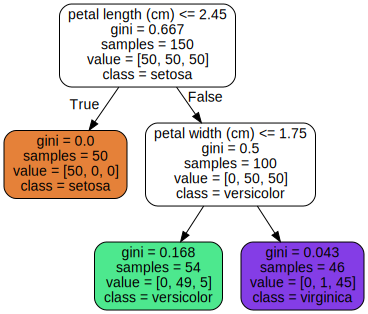

In [8]:
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file="iris_tree.dot",
        feature_names=feature_names,
        class_names=class_names,
        rounded=True,
        filled=True
    )

Source.from_file("iris_tree.dot")

## 2.3 Use implemented SimpleDecisionTreeClassifier

In [9]:
tree_clf = SimpleDecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

Training...
Training completed!


In [10]:
# Visualize.
tree_clf.debug(
    feature_names=feature_names,
    class_names=class_names,
)

                    ┌─────────────────────────────┐                                                                          
                    │ Ft. petal width (cm) < 0.55 │                                                                          
                    │         gini = 0.67         │                                                                          
                    │        samples = 150        │                                                                          
          ┌─────────┤     val = [50, 50, 50]      ├─────────────────────────────────────┐                                    
          │         └─────────────────────────────┘                                     │                                    
╔═════════╧════════╗                                                     ┌──────────────┴──────────────┐                     
║  class = setosa  ║                                                     │ Ft. petal width (cm) < 1.75 │              

# 3. Wireless Indoor Localization Data Set

## 3.1 Read data

It gives 7 features representing the strength of 7 Wi-Fi signals perceived by a phone in an apartment, along with the indoor location of the phone which can be Room 1, 2, 3 or 4.

The goal is to predict which room the phone is located in based on the strength of Wi-Fi signals

In [11]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00422/wifi_localization.txt'
df  = pd.read_csv(url, delimiter='\t')
df.head(5)

,-64,-56,-61,-66,-71,-82,-81,1
0,-68,-57,-61,-65,-71,-85,-85,1
1,-63,-60,-60,-67,-76,-85,-84,1
2,-61,-60,-68,-62,-77,-90,-80,1
3,-63,-65,-60,-63,-77,-81,-87,1
4,-64,-55,-63,-66,-76,-88,-83,1


In [12]:
df = df.to_numpy()
print('df.shape: ', df.shape)
print('df: ', df)

df.shape:  (1999, 8)
df:  [[-68 -57 -61 ... -85 -85   1]
 [-63 -60 -60 ... -85 -84   1]
 [-61 -60 -68 ... -90 -80   1]
 ...
 [-62 -59 -46 ... -87 -88   4]
 [-62 -58 -52 ... -90 -85   4]
 [-59 -50 -45 ... -88 -87   4]]


In [13]:
X = df[:, :-1]
y = df[:, -1]

In [14]:
features_names = ['Wifi {}'.format(i) for i in range(1, 8)]
target_names   = ['Room {}'.format(i) for i in range(1, 5)]
print('features_names: ', features_names)
print('target_names: ', target_names)

features_names:  ['Wifi 1', 'Wifi 2', 'Wifi 3', 'Wifi 4', 'Wifi 5', 'Wifi 6', 'Wifi 7']
target_names:  ['Room 1', 'Room 2', 'Room 3', 'Room 4']


## 3.2 Use Sklearn DecisionTreeClassifier

In [15]:
# Training
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

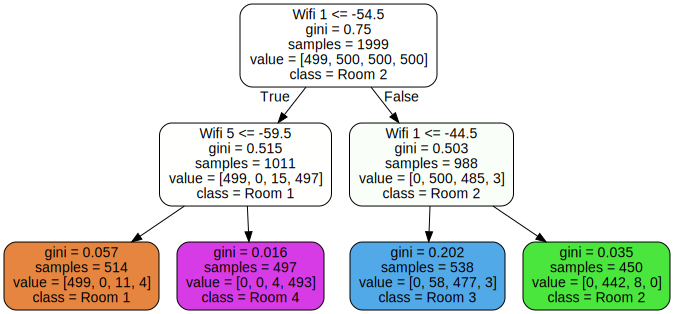

In [16]:
export_graphviz(
        tree_clf,
        out_file="wifi_tree.dot",
        feature_names=features_names,
        class_names=target_names,
        rounded=True,
        filled=True
    )

Source.from_file("wifi_tree.dot")

## 3.3 Use implemented SimpleDecisionTreeClassifier

In [17]:
tree_clf = SimpleDecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

Training...
Training completed!


In [18]:
X_test = [-61, -5, -49, -6, -77, -77, -82]
pred_class_id = tree_clf.predict( [X_test] )[0]
print('X_test: ', X_test)
print('Prediction: ID = {}, class = {}'.format(pred_class_id, target_names[pred_class_id]))

print()
X_test = [-70, 0, 0, 0, -40, 0, 0]
pred_class_id = tree_clf.predict( [X_test] )[0]
print('X_test: ', X_test)
print('Prediction: ID = {}, class = {}'.format(pred_class_id, target_names[pred_class_id]))

X_test:  [-61, -5, -49, -6, -77, -77, -82]
Prediction: ID = 0, class = Room 1

X_test:  [-70, 0, 0, 0, -40, 0, 0]
Prediction: ID = 3, class = Room 4


In [20]:
# Visualize.
tree_clf.debug(
    feature_names=features_names,
    class_names=target_names,
)

                                                                            ┌────────────────────────────┐                                                                           
                                                                            │    Ft. Wifi 1 < -54.50     │                                                                           
                                                                            │        gini = 0.75         │                                                                           
                                                                            │       samples = 1999       │                                                                           
                                      ┌─────────────────────────────────────┤ val = [499, 500, 500, 500] ├──────────────────────────────────────┐                                    
                                      │                                     └─────────────